# 1. Load Data

In [1]:
import numpy as np
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# 1：load features
atomic_number = np.load('atNUM.npy')  # shape: (23, num_molecules)
coordinates = np.load('atXYZ.npy')    #  (3, 23, num_molecules)
hDIP = np.load('hDIP.npy')            #  (23, num_molecules)
atPOL = np.load('atPOL.npy')          #  (23, num_molecules)
vdwR = np.load('vdwR.npy')            #  (23, num_molecules)

# combine features hDIP、atPOL、dwR 
features = np.stack((hDIP, atPOL, vdwR), axis=1)  # 形状: (23, 3, num_molecules)

# 2：normalize
num_features = features.shape[1]
mu_x, var_x = np.zeros(num_features), np.zeros(num_features)
for i in range(num_features):
    X = features[:, i, :][features[:, i, :] != 0]  # clean 0 
    mu_x[i], var_x[i] = np.mean(X), np.var(X, ddof=1)

def normalize_features(features, mu_x, var_x):
    for j in range(features.shape[2]):  # all molecules
        valid_idx = np.nonzero(features[:, 0, j])[0]  # non zero indexs
        features[valid_idx, :, j] = (features[valid_idx, :, j] - mu_x) / np.sqrt(var_x)
    return features

features = normalize_features(features, mu_x, var_x)

# 2.load adj and labels
adjacency = np.load('adjacency.npy')
labels = json.load(open('labels.json', 'r'))

# 3：split data
num_graphs = adjacency.shape[2]
indices = np.arange(num_graphs)
idx_train, idx_temp = train_test_split(indices, train_size=0.8, random_state=42)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=42)

features_train = features[:, :, idx_train]
features_val = features[:, :, idx_val]
features_test = features[:, :, idx_test]

adjacency_train = adjacency[:, :, idx_train]
adjacency_val = adjacency[:, :, idx_val]
adjacency_test = adjacency[:, :, idx_test]

labels_train = [labels[i] for i in idx_train]
labels_val = [labels[i] for i in idx_val]
labels_test = [labels[i] for i in idx_test]

# 4：one hot labels
class_names = sorted(set(label for sublist in labels for label in sublist))
mlb = MultiLabelBinarizer(classes=class_names)
labels_train_bin = mlb.fit_transform(labels_train)
labels_val_bin = mlb.transform(labels_val)
labels_test_bin = mlb.transform(labels_test)

# 5：data to DataLoader
features_train_tensor = torch.tensor(features_train.transpose(2, 0, 1), dtype=torch.float32)  # shape: (num_graphs_train, 23, 3)
adjacency_train_tensor = torch.tensor(adjacency_train.transpose(2, 0, 1), dtype=torch.float32)  # shape: (num_graphs_train, 23, 23)
labels_train_tensor = torch.tensor(labels_train_bin, dtype=torch.float32)  # shape: (num_graphs_train, num_classes)

features_val_tensor = torch.tensor(features_val.transpose(2, 0, 1), dtype=torch.float32)  # 形状: (num_graphs_val, 23, 3)
adjacency_val_tensor = torch.tensor(adjacency_val.transpose(2, 0, 1), dtype=torch.float32)  # 形状: (num_graphs_val, 23, 23)
labels_val_tensor = torch.tensor(labels_val_bin, dtype=torch.float32)  # 形状: (num_graphs_val, num_classes)

features_test_tensor = torch.tensor(features_test.transpose(2, 0, 1), dtype=torch.float32)  # 形状: (num_graphs_test, 23, 3)
adjacency_test_tensor = torch.tensor(adjacency_test.transpose(2, 0, 1), dtype=torch.float32)  # 形状: (num_graphs_test, 23, 23)
labels_test_tensor = torch.tensor(labels_test_bin, dtype=torch.float32)  # 形状: (num_graphs_test, num_classes)

# save data as torch format
torch.save({'features_train': features_train_tensor,
            'adjacency_train': adjacency_train_tensor,
            'labels_train': labels_train_tensor,
            'features_val': features_val_tensor,
            'adjacency_val': adjacency_val_tensor,
            'labels_val': labels_val_tensor,
            'features_test': features_test_tensor,
            'adjacency_test': adjacency_test_tensor,
            'labels_test': labels_test_tensor},
           'processed_data.pt')

# shape
print("train feature:", features_train_tensor.shape)
print("train adj:", adjacency_train_tensor.shape)
print("train label:", labels_train_tensor.shape)
print("val   feature:", features_val_tensor.shape)
print("val   adj:", adjacency_val_tensor.shape)
print("val   label:", labels_val_tensor.shape)
print("test  feature:", features_test_tensor.shape)
print("test  adj:", adjacency_test_tensor.shape)
print("test  label:", labels_test_tensor.shape)

train feature: torch.Size([5560, 23, 3])
train adj: torch.Size([5560, 23, 23])
train label: torch.Size([5560, 8])
val   feature: torch.Size([695, 23, 3])
val   adj: torch.Size([695, 23, 23])
val   label: torch.Size([695, 8])
test  feature: torch.Size([695, 23, 3])
test  adj: torch.Size([695, 23, 23])
test  label: torch.Size([695, 8])


# 2. Define Model

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
# from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import math
import time

# Glorot initialization function
def initialize_glorot(shape, num_out, num_in, dtype=torch.float32):
    bound = math.sqrt(6 / (num_in + num_out))
    weights = torch.empty(shape, dtype=dtype).uniform_(-bound, bound)
    return weights

class MultiMaskGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, device):
        """
        Initializes the MultiMaskGAT model.
        Args:
            in_channels (int): Number of input features per node.
            hidden_channels (int): Number of hidden features.
            out_channels (int): Number of output features per node.
            num_heads (NumHeads): Number of heads for each attention layer.
            device (torch.device): Device to run the model on (CPU or GPU).
        """
        super(MultiMaskGAT, self).__init__()
        
        # Attention layers
        self.attn1 = GATConv(in_channels, hidden_channels, heads=num_heads.attn1, concat=True, dropout=0.0)
        self.attn2 = GATConv(hidden_channels * num_heads.attn1, hidden_channels, heads=num_heads.attn2, concat=True, dropout=0.0)
        self.attn3 = GATConv(hidden_channels * num_heads.attn2, out_channels, heads=num_heads.attn3, concat=False, dropout=0.0)
        
        # Initialize weights using Glorot (Xavier) initialization
        self._initialize_weights()
        
        # Set device
        self.device = device
        self.to(device)

    def _initialize_weights(self):
        """
        Initializes the weights of GAT layers using the Glorot (Xavier) method.
        """
        for m in self.modules():
            if isinstance(m, GATConv):
                if m.lin_src is not None:
                    m.lin_src.weight.data = initialize_glorot(m.lin_src.weight.shape, m.out_channels, m.in_channels)
                if m.lin_dst is not None:
                    m.lin_dst.weight.data = initialize_glorot(m.lin_dst.weight.shape, m.out_channels, m.in_channels)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, x, edge_index, batch):
        """
        Forward pass of the model.
        Args:
            x (torch.Tensor): Node feature matrix.
            edge_index (torch.Tensor): Graph connectivity matrix.
            batch (torch.Tensor): Batch vector, which assigns each node to a specific graph.
        Returns:
            torch.Tensor: Output predictions.
        """
        # First attention layer with ELU activation
        x = self.attn1(x, edge_index)
        x = F.elu(x)
        
        # Second attention layer with ELU activation and residual connection
        x_res = x  # Residual connection
        x = self.attn2(x, edge_index)
        x = F.elu(x) + x_res
        
        # Third attention layer
        x = self.attn3(x, edge_index)
        
        # Global average pooling to get graph-level representation
        x = global_mean_pool(x, batch)
        
        # Sigmoid activation for multi-label classification
        x = torch.sigmoid(x)
        return x

# 3. Train Setting

In [61]:
# Assuming graph features, adjacency matrices, and labels are prepared
# Define number of heads for each attention layer based on MATLAB parameters
class NumHeads:
    def __init__(self):
        """
        Initializes the number of heads for each attention layer.
        """
        self.attn1 = 3
        self.attn2 = 3
        self.attn3 = 5

# Model loss function
def model_loss(model, data):
    """
    Computes the loss for the given data.
    Args:
        model (MultiMaskGAT): The GAT model.
        data (torch_geometric.data.Data): Graph data.
    Returns:
        torch.Tensor: Computed loss.
    """
    # Forward pass to get predictions
    out = model(data.x.to(model.device), data.edge_index.to(model.device), data.batch.to(model.device))
    
    # Calculate binary cross-entropy loss
    loss = F.binary_cross_entropy(out, data.y.view_as(out).to(model.device))
    
    return loss

# Validation function
def validate(model, validation_loader):
    """
    Validates the model on the validation set.
    Args:
        model (MultiMaskGAT): The GAT model.
        validation_loader (DataLoader): DataLoader for the validation set.
    Returns:
        torch.Tensor: Average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(model.device)
            out = model(data.x, data.edge_index, data.batch)
            val_loss = F.binary_cross_entropy(out, data.y.view_as(out))
            total_val_loss += val_loss * data.num_graphs
    return total_val_loss / len(validation_loader.dataset)

# Training loop
def train(model, train_loader, optimizer, epochs=70, validation_loader=None, validation_frequency=210, test_loader=None):
    """
    Trains the model.
    Args:
        model (MultiMaskGAT): The GAT model.
        train_loader (DataLoader): DataLoader for the training set.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.
        validation_loader (DataLoader, optional): DataLoader for the validation set.
        validation_frequency (int, optional): Frequency of validation.
        test_loader (DataLoader, optional): DataLoader for the test set.
    """
    log = []
    start_time = time.time()
    train_losses = []
    val_losses = []
    test_losses = []
    iteration_losses = []
    iteration = 0

    print(f"Training dataset shape: {len(train_loader.dataset)}")
    if validation_loader is not None:
        print(f"Validation dataset shape: {len(validation_loader.dataset)}")
    if test_loader is not None:
        print(f"Test dataset shape: {len(test_loader.dataset)}")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            # Calculate loss
            loss = model_loss(model, data)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * data.num_graphs
            iteration += 1
            iteration_losses.append((iteration, loss.item()))
            
        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append((epoch, avg_train_loss))
        
        # Validation and Test after each epoch
        if validation_loader is not None:
            val_loss = validate(model, validation_loader)
            val_losses.append((epoch, val_loss.item()))
            
            if test_loader is not None:
                test_loss = validate(model, test_loader)
                test_losses.append((epoch, test_loss.item()))
                log.append(f"Epoch: {epoch+1}, Loss: {avg_train_loss:.4f}, Val: {val_loss:.4f}, Test: {test_loss:.4f}, Time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
                print(log[-1])
            else:
                log.append(f"Epoch: {epoch+1}, Loss: {avg_train_loss:.4f}, Val: {val_loss:.4f}, Time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
                print(log[-1])
        else:
            log.append(f"Epoch: {epoch+1}, Loss: {avg_train_loss:.4f}, Time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
            print(log[-1])
    
    end_time = time.time()
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
    log.append(f"Training completed in {elapsed_time}")
    print(log[-1])
    end_time = time.time()
    elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
    log.append(f"Training completed in {elapsed_time}")
    print(log[-1])

    # Plot training, validation, and test loss
    plt.figure(figsize=(4, 3))
    plt.plot(*zip(*train_losses), label='Training Loss', color='#1f77b4')  # Blue color for training loss
    if validation_loader is not None:
        plt.plot(*zip(*val_losses), linestyle='-', label='Validation Loss', color='#ff7f0e')  # Orange color for validation loss
    if test_loader is not None:
        plt.plot(*zip(*test_losses), linestyle='-', label='Test Loss', color='#2ca02c')  # Green color for test loss
    plt.ylim(0.1,0.7)
    plt.xlabel("Epoch", fontsize=11)
    plt.ylabel("Loss", fontsize=11)
    plt.title(f"Training Progress (Elapsed: {elapsed_time})", fontsize=11)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_progress_epoch.png")
    plt.show()

    # # Plot training, validation, and test loss against iterations
    # plt.figure(figsize=(4, 3))
    # plt.plot([i for i, _ in iteration_losses], [loss for _, loss in iteration_losses], label='Training Loss', color='#1f77b4')  # Blue color for training loss
    # if validation_loader is not None:
    #     plt.plot([i for i in range(len(val_losses))], [loss[1] for loss in val_losses], linestyle='-', label='Validation Loss', color='#ff7f0e')  # Orange color for validation loss
    # if test_loader is not None:
    #     plt.plot([i for i in range(len(test_losses))], [loss[1] for loss in test_losses], linestyle='-', label='Test Loss', color='#2ca02c')  # Green color for test loss
    # plt.ylim(0.1,0.7)
    # plt.xlabel("Iteration", fontsize=11)
    # plt.ylabel("Loss", fontsize=11)
    # plt.title(f"Training Progress (Elapsed: {elapsed_time})", fontsize=11)
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig("training_progress_iteration.png")
    # plt.show()

# 4. Train

Training dataset shape: 5560
Validation dataset shape: 695
Test dataset shape: 695
Epoch: 1, Loss: 0.4531, Val: 0.4120, Test: 0.4165, Time: 00:00:01
Epoch: 2, Loss: 0.3931, Val: 0.3729, Test: 0.3769, Time: 00:00:02
Epoch: 3, Loss: 0.3665, Val: 0.3569, Test: 0.3583, Time: 00:00:03
Epoch: 4, Loss: 0.3561, Val: 0.3468, Test: 0.3514, Time: 00:00:03
Epoch: 5, Loss: 0.3442, Val: 0.3297, Test: 0.3346, Time: 00:00:04
Epoch: 6, Loss: 0.3207, Val: 0.3248, Test: 0.3195, Time: 00:00:05
Epoch: 7, Loss: 0.2968, Val: 0.2719, Test: 0.2697, Time: 00:00:06
Epoch: 8, Loss: 0.2633, Val: 0.2569, Test: 0.2467, Time: 00:00:07
Epoch: 9, Loss: 0.2440, Val: 0.2335, Test: 0.2238, Time: 00:00:08
Epoch: 10, Loss: 0.2214, Val: 0.2206, Test: 0.2091, Time: 00:00:09
Epoch: 11, Loss: 0.2050, Val: 0.1973, Test: 0.1957, Time: 00:00:10
Epoch: 12, Loss: 0.1958, Val: 0.1854, Test: 0.1791, Time: 00:00:11
Epoch: 13, Loss: 0.1941, Val: 0.1896, Test: 0.1799, Time: 00:00:12
Epoch: 14, Loss: 0.1808, Val: 0.1778, Test: 0.1745, Tim

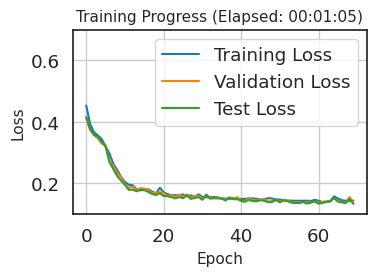

In [62]:
# Assuming your graph features and adjacency matrices are prepared in a way compatible with PyTorch Geometric
def prepare_data(features, adjacency, labels):
    # Prepare PyTorch Geometric graph data
    data_list = []
    num_graphs = features.shape[0]
    for i in range(num_graphs):
        # x = torch.tensor(features[i], dtype=torch.float)  # Node features: Shape (num_nodes, num_features)
        x = features[i].clone().detach()
        edge_index = torch.nonzero(adjacency[i], as_tuple=False).t().contiguous()  # Edge index for GAT
        # y = torch.tensor(labels[i], dtype=torch.float)  # Labels for multi-label classification
        y = labels[i].clone().detach()
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

###############*******************#######################******************###############
# Initialize model parameters
in_channels = features_train_tensor.shape[-1]
hidden_channels = 96  
out_channels = labels_train_tensor.shape[-1]
num_heads = NumHeads()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance
model = MultiMaskGAT(in_channels, hidden_channels, out_channels, num_heads, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Prepare dataset using your features, adjacency, and labels
train_list = prepare_data(features_train_tensor, adjacency_train_tensor, labels_train_tensor)
val_list = prepare_data(features_val_tensor, adjacency_val_tensor, labels_val_tensor)
test_list = prepare_data(features_test_tensor, adjacency_test_tensor, labels_test_tensor)
train_loader = DataLoader(train_list, batch_size=300, shuffle=True)
validation_loader = DataLoader(val_list, batch_size=300, shuffle=True)
test_loader = DataLoader(test_list, batch_size=300, shuffle=True)
# Start training
train(model, train_loader, optimizer, validation_loader=validation_loader, test_loader=test_loader)

# 5.Test

In [10]:
# save model
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved as 'trained_model.pth'")

Model saved as 'trained_model.pth'


In [11]:
import torch
from torch_geometric.loader import DataLoader  # 更新为 loader.DataLoader
from torch_geometric.data import Data
from sklearn.metrics import fbeta_score
import pandas as pd

# load gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
data = torch.load('processed_data.pt')

features_test_tensor = data['features_test'].to(device)  # (num_graphs_test, num_nodes, num_features)
adjacency_test_tensor = data['adjacency_test'].to(device)  # (num_graphs_test, num_nodes, num_nodes)
labels_test_tensor = data['labels_test'].to(device)  # (num_graphs_test, num_classes)

# PyTorch Geometric
def prepare_data(features, adjacency, labels):
    data_list = []
    num_graphs = features.shape[0]
    for i in range(num_graphs):
        x = features[i]  # Node features: Shape (num_nodes, num_features)
        edge_index = torch.nonzero(adjacency[i], as_tuple=False).t().contiguous()  # Edge index for GAT
        y = labels[i]  # Labels for multi-label classification
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

# test data to DataLoader
data_list_test = prepare_data(features_test_tensor, adjacency_test_tensor, labels_test_tensor)
mini_batch_size = 300
test_loader = DataLoader(data_list_test, batch_size=mini_batch_size, shuffle=False)

# load model
model = MultiMaskGAT(
    in_channels=features_test_tensor.shape[-1],
    hidden_channels=96,
    out_channels=labels_test_tensor.shape[-1],
    num_heads=num_heads,
    device=device
)
model.load_state_dict(torch.load('trained_model.pth', map_location=device))
model.to(device)
model.eval()

# prediction
predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        # node feature, node index, batch setting
        output = model(batch.x, batch.edge_index, batch.batch)
        predictions.append(output)

predictions = torch.cat(predictions, dim=0).cpu().numpy()

# 0.5 stand prob to 01labels
Y_test = (predictions >= 0.5).astype(int)
T_test = labels_test_tensor.cpu().numpy()

# beta-F-score
score_weight = [0.5, 1, 2]
score_test = [fbeta_score(T_test, Y_test, beta=beta, average='macro') for beta in score_weight]

# print score
score_test_tbl = pd.DataFrame({
    'Beta': score_weight,
    'FScore': score_test
})

print(score_test_tbl)

   Beta    FScore
0   0.5  0.760612
1   1.0  0.731395
2   2.0  0.726759


# visualization

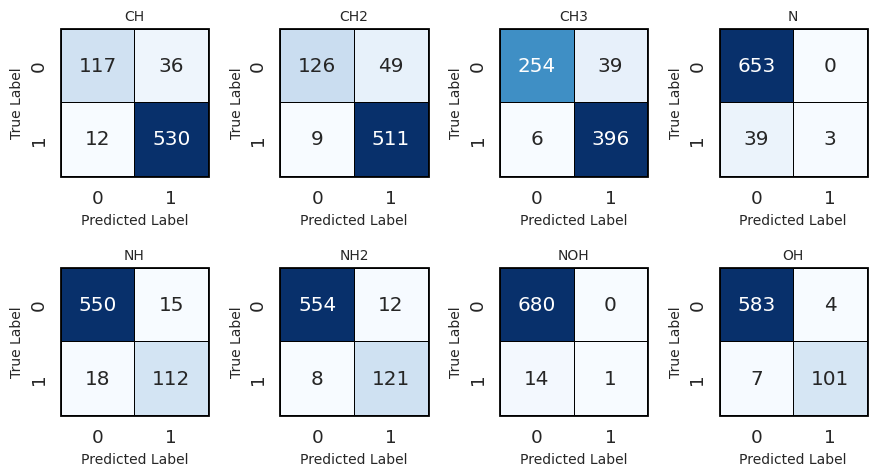

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# plot confusion matrix
def plot_confusion_matrices(Y_test, T_test, class_names, font_scale=1.0, font_dict=None):
    sns.set(font_scale=font_scale)  # Set font size
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 1) // 4, ncols=4, figsize=(9, 5))
    axes = axes.flatten()

    if font_dict is None:
        font_dict = {'fontsize': 10}  # Default font dictionary

    for i in range(num_classes):
        cm = confusion_matrix(T_test[:, i], Y_test[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, linewidths=0.5, linecolor='black')
        axes[i].set_title(f'{class_names[i]}', fontdict=font_dict)
        axes[i].set_xlabel('Predicted Label', fontdict=font_dict)
        axes[i].set_ylabel('True Label', fontdict=font_dict)

        # Ensure all borders, including heatmap grid, are drawn
        for spine in axes[i].spines.values():
            spine.set_linewidth(2)

        # Fix missing lower-right border for heatmap
        axes[i].patch.set_edgecolor('black')
        axes[i].patch.set_linewidth(2)

    # Adjust layout to ensure all subplots fit nicely
    plt.tight_layout()
    plt.show()

# plot
plot_confusion_matrices(Y_test, T_test, class_names, font_scale=1.2, font_dict={'fontsize': 10})


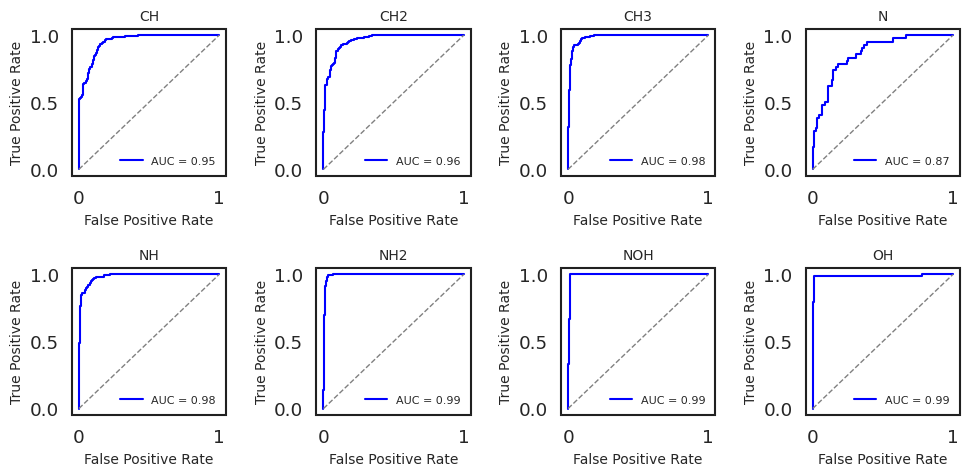

In [60]:
# plot ROC curves
def plot_roc_curves(predictions, T_test, class_names, font_scale=1.0, font_dict=None):
    sns.set(font_scale=font_scale, style='white')  # Set font size and remove grid background
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 1) // 4, ncols=4, figsize=(10, 5))
    axes = axes.flatten()

    if font_dict is None:
        font_dict = {'fontsize': 10}  # Default font dictionary

    for i in range(num_classes):
        current_targets = T_test[:, i]
        current_predictions = predictions[:, i]

        # Compute true positive rate and false positive rate
        fpr, tpr, _ = roc_curve(current_targets, current_predictions)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=1.5, color='blue')
        axes[i].plot([0, 1], [0, 1], '--', color='gray', linewidth=1.0)
        axes[i].set_title(f'{class_names[i]}', fontdict=font_dict)
        axes[i].set_xlabel('False Positive Rate', fontdict=font_dict)
        axes[i].set_ylabel('True Positive Rate', fontdict=font_dict)
        axes[i].legend(loc='lower right', fontsize=8, frameon=False)  # Avoid overlap with curve

        # # Ensure all borders are drawn
        # for spine in axes[i].spines.values():
        #     spine.set_linewidth(1.5)

        # Add border to the subplot area
        axes[i].patch.set_edgecolor('black')
        axes[i].patch.set_linewidth(1.5)

    # Hide extra subplots if necessary
    for j in range(len(axes)):
        if j >= num_classes:
            fig.delaxes(axes[j])


    plt.tight_layout()
    plt.show()

plot_roc_curves(predictions, T_test, class_names, font_scale=1.2, font_dict={'fontsize': 10})